<a href="https://colab.research.google.com/github/Shobhit2000/Traffic_Sign_Classifier/blob/master/Traffic_Sign_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
import os
import random
import pickle
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
np.random.seed(0)

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


Using TensorFlow backend.


**ASSIGNING THE DATA TO TRAIN, VALIDATION AND TEST SET**

In [0]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data=pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data=pickle.load(f)

**ASSIGNING FEATURES AND LABELS TO X ND Y VARIABLES**

In [4]:
X_train , Y_train= train_data['features'], train_data['labels']
X_val , Y_val= val_data['features'], val_data['labels']
X_test , Y_test= test_data['features'], test_data['labels']
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


**DATA VISUALIZATION**

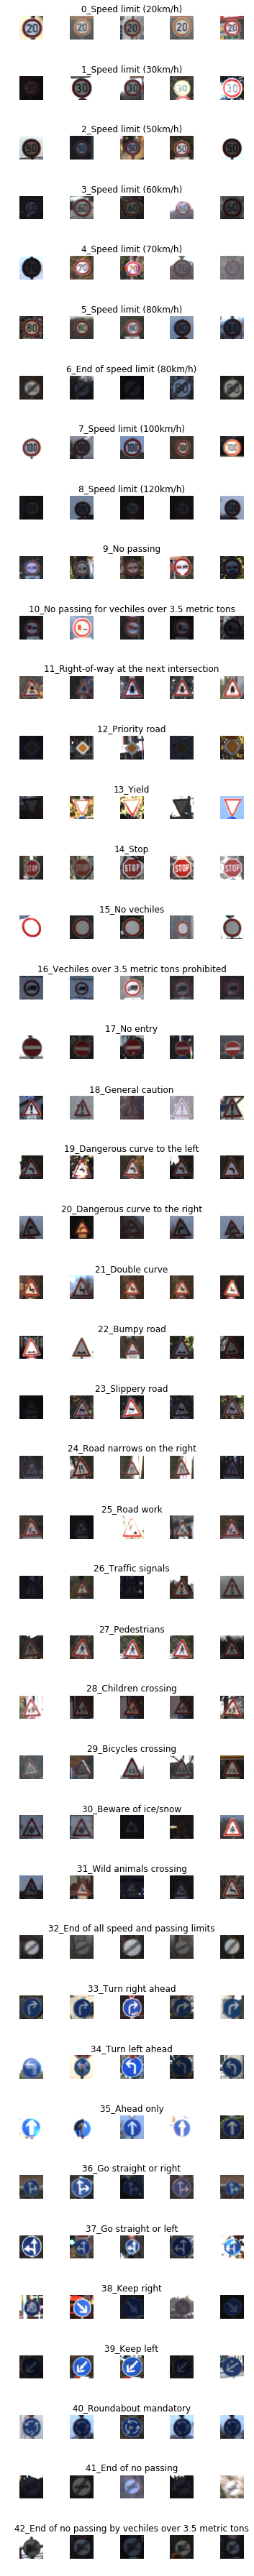

In [5]:
data= pd.read_csv('german-traffic-signs/signnames.csv')

num_samples=[]

cols=5
num_classes=43

fig,axs=plt.subplots(nrows=num_classes, ncols=5, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[Y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + "_" + row["SignName"])
      num_samples.append(len(x_selected))

In [29]:
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Num of Samples')

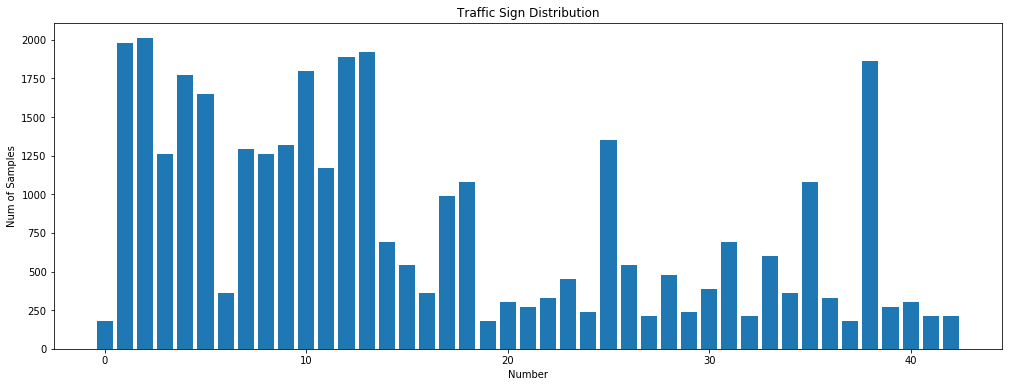

In [6]:
print(num_samples)
plt.figure(figsize=(17,6))
plt.bar(range(0,num_classes),num_samples)
plt.title('Traffic Sign Distribution')
plt.xlabel('Number')
plt.ylabel('Num of Samples')

**DATA PREPROCESSING**

(34799, 32, 32, 3)
31


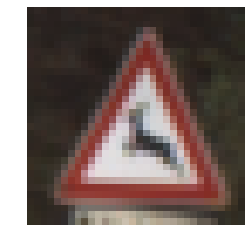

In [7]:
plt.imshow(X_train[500])
plt.axis('off')
print(X_train.shape)
print(Y_train[500])

In [0]:
def grayscale(img):
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  plt.axis('off')
  return img

(32, 32)


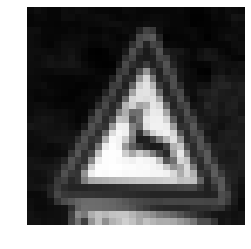

In [9]:
img=grayscale(X_train[500])
plt.imshow(img, cmap='gray')
print(img.shape)

In [0]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

(32, 32)


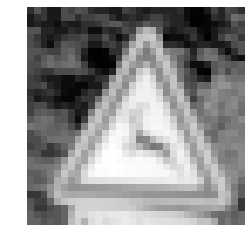

In [11]:
img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img= equalize(img)
  img= img/255
  return img

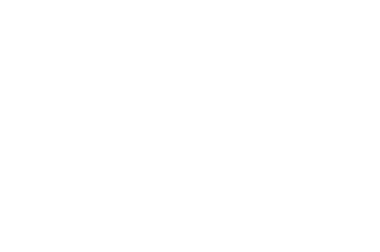

In [13]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [0]:
X_train= X_train.reshape(34799,32,32,1)
X_val= X_val.reshape(4410,32,32,1)
X_test= X_test.reshape(12630,32,32,1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen= ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1 , rotation_range = 20, zoom_range = 0.2)
datagen.fit(X_train)

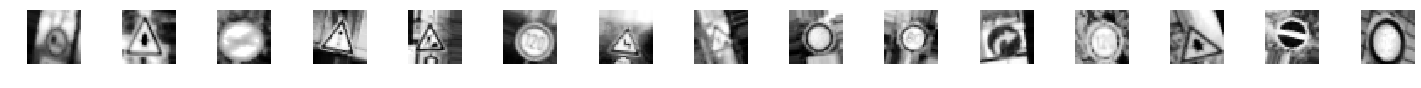

In [16]:
batches= datagen.flow(X_train, Y_train, batch_size=20)
X_batch, Y_batch= next(batches)
fig, axs = plt.subplots(1,15,figsize=(20,5))
plt.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32), cmap='gray')
  axs[i].axis('off')

In [0]:
Y_train = to_categorical(Y_train, 43)
Y_val = to_categorical(Y_val, 43)
Y_test = to_categorical(Y_test, 43)

**NEURAL NETWORK**

In [0]:
def create_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [19]:
model = create_model()
print(model.summary())

W0614 07:59:39.697441 139887182514048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 07:59:39.735050 139887182514048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 07:59:39.742163 139887182514048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 07:59:39.786365 139887182514048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0614 07:59:39.849436 139887182514048 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

In [20]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 50), steps_per_epoch =2000, epochs = 10, validation_data =(X_val, Y_val), shuffle = 1)

W0614 07:59:52.862580 139887182514048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
2000/2000 [==============================] - 59s 30ms/step - loss: 1.1416 - acc: 0.6675 - val_loss: 0.1028 - val_acc: 0.9714
Epoch 2/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.3121 - acc: 0.9021 - val_loss: 0.0593 - val_acc: 0.9821
Epoch 3/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.2159 - acc: 0.9330 - val_loss: 0.0479 - val_acc: 0.9868
Epoch 4/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.1709 - acc: 0.9470 - val_loss: 0.0498 - val_acc: 0.9853
Epoch 5/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.1470 - acc: 0.9548 - val_loss: 0.0508 - val_acc: 0.9859
Epoch 6/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.1273 - acc: 0.9610 - val_loss: 0.0319 - val_acc: 0.9918
Epoch 7/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.1181 - acc: 0.9637 - val_loss: 0.0473 - val_acc: 0.9868
Epoch 8/10
2000/2000 [==========================

**Save the Full Model**

In [0]:
model.save('traffic_sign.h5')

Text(0.5, 0, 'epoch')

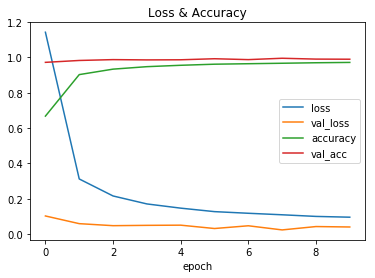

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['loss', 'val_loss', 'accuracy', 'val_acc'])
plt.title('Loss & Accuracy')
plt.xlabel('epoch')

In [48]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test Score = ',score[0])
print('Test accuracy = ',score[1])

12630/12630 [==============================] - 2s 135us/step
Test Score =  0.12473030524780901
Test accuracy =  0.9705463183086633


**TESTING SAMPLE IMAGES**

In [23]:
from google.colab import files
files.upload()

Saving sample 4.jpg to sample 4.jpg


{'sample 4.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0 (using IJG JPEG v62), quality = 80\n\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x03o\x05\x14\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x01\x02\x03\x05\x06\x07\x08\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xe4X\xcc\xbe\x0c^\x16\xadh\x83D\xd8\xe7\x9cC\xae\x1e\x82\xb0\x0b\xd1FOG\x8fr,\xd2\x00\x8cQxg\x03\xa0-\x14\xd1\xd3Et9\xda\xfc\x92\xe1\x9bNj\xe6\x16MUK6\x95\xabTH\xc5b\x1c\xd0\x

(-0.5, 1299.5, 878.5, -0.5)

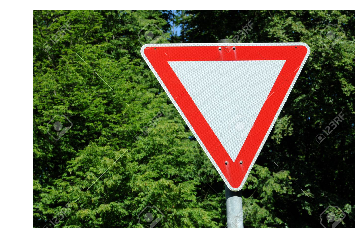

In [41]:
from PIL import Image

image = Image.open('sample 4.jpg')
plt.imshow(image)
plt.axis('off')

(32, 32)


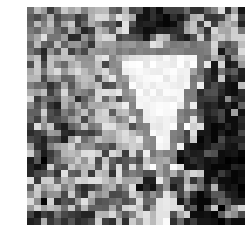

In [42]:
img = np.asarray(image)
img = cv2.resize(img , (32 , 32))
img = preprocessing(img)

print(img.shape)
plt.imshow(img , cmap= 'gray')
img  = img.reshape(1 , 32 , 32 , 1)

In [43]:
prediction = model.predict_classes(img)
print(prediction)

[13]


13
Predicted number  = 13
Predicted Sign = Yield


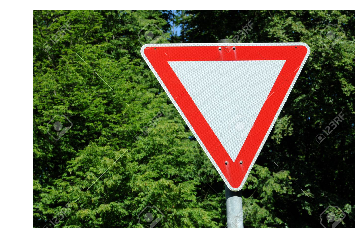

In [45]:
pred = prediction[0]
print(pred)

for i in range(44):
  if(pred == i):
    print("Predicted number  = " + str(pred))
    print("Predicted Sign = " + str(data['SignName'][i]))
    plt.imshow(image)
    plt.axis('off')